In [113]:
import scipy.io as scio
import pandas as pd
import numpy as np
import os
from pandas import Series,DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

from sklearn.decomposition import PCA

sns.set()

In [85]:
random.seed(3345)

In [86]:
def distance_feature(x): # calcuate distance between points, choose uprigt triangle
    #sqrt(dx^2+dy^2)
    a = (x[None, :, :] - x[:, None, :])
    b = np.linalg.norm(a, axis=2)
    return b[np.triu_indices(78, 1)] # feature size (78-1)(78-2) /2 

In [87]:
def euc_distance_feature(x): # instead of distance, keep two dimensional distance vector
    #(dx,dy)
    a = (x[None, :, :] - x[:, None, :])
    index = np.triu_indices(78, 1)
    b = a[index]
    return b.reshape((-1,)) # feature size (78-1)(78-2) /2 * 2

In [88]:
df = pd.read_csv("../../data/train_set/label.csv")
labels = df["emotion_idx"].tolist()

In [89]:
data = list()
for i in range(1, 2501):
    name = "../../data/train_set/points/%04d.mat" % i
    dic = scio.loadmat(name)
    if "faceCoordinatesUnwarped" in dic:
        data.append(dic["faceCoordinatesUnwarped"])
    else:
        data.append(dic["faceCoordinates2"])

In [90]:
# shuffle data
data, labels = shuffle(data, labels, random_state=0)

### First we try the distance as features 

In [27]:
features = [distance_feature(d) for d in data]

In [28]:
len(features[0])

3003

In [29]:
distance_feature(data[0])

array([ 36.34978226,  22.49500156,   8.99027133, ...,  53.06069409,
       105.97379197,  52.97335008])

In [30]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2)

GBM 

In [31]:
param_grid = [
  {'learning_rate':[0.01],
   'n_estimators': [10,20,50,80,100], 
   'max_depth':[5,10,15],
   'max_leaf_nodes':[5,15,25],
   'random_state':[10]
  }
 ]
# Cross-validation grid-search
clf = GridSearchCV( GradientBoostingClassifier(), 
   param_grid, cv=3)
clf.fit(train_x,train_y)
print("Best parameters set found:")
print(clf.best_params_)
best_params = clf.best_params_

KeyboardInterrupt: 

In [158]:
gbm = GradientBoostingClassifier(learning_rate=0.01,n_estimators=30,random_state=10).fit(train_x, train_y)

In [159]:
gbm.score(train_x, train_y)

0.6645

In [160]:
gbm.score(test_x, test_y)

0.358

Logistic Regression

In [135]:
clf = LogisticRegression(max_iter=800, penalty = "l2", random_state=0, solver='lbfgs', multi_class='multinomial', n_jobs=-1).fit(train_x, train_y)

In [136]:
clf.score(train_x, train_y)

0.8605

In [137]:
clf.score(test_x, test_y)

0.532

Random Forest

In [32]:
forest = RandomForestClassifier(n_estimators=500, oob_score = True, 
                                max_depth=12, max_leaf_nodes=15,
                                max_features="auto", n_jobs=-1)

In [33]:
forest.fit(train_x, train_y)
print(forest.score(train_x, train_y))
print(forest.score(test_x, test_y))
print(forest.oob_score_)

0.46
0.338
0.332


### Second we try euclidien distance as features 

In [94]:
features2 = [euc_distance_feature(d) for d in data]

In [92]:
train_x, test_x, train_y, test_y = train_test_split(features2, labels, test_size=0.2)

In [128]:
clf = LogisticRegression(max_iter=800, random_state=0,  penalty = "l2", solver='lbfgs', multi_class='multinomial', n_jobs=-1).fit(train_x, train_y)

In [129]:
clf.score(train_x, train_y)

0.8705

In [130]:
clf.score(test_x, test_y)

0.542

xgboost

In [ ]:
import xgboost as xgb

In [ ]:
D_train = xgb.DMatrix(train_x, label=train_y)
D_test = xgb.DMatrix(test_x, label=test_y)

In [ ]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.10, 0.20, 0.30 ],
     "max_depth"        : [ 3, 5,8,10,12],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.2 , 0.4 ],
     "colsample_bytree" : [ 0.3, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(train_x, train_y)

print("Best parameters set found:")
print(grid.best_params_)
best_params = grid.best_params_

In [ ]:
xgb = xgb.XGBClassifier(best_params).fit(train_x, train_y)

In [ ]:
xgb.score(train_x, train_y)

In [ ]:
xgb.score(test_x, test_y)

### KNN

In [95]:
train_x, test_x, train_y, test_y = train_test_split(features2, labels, test_size=0.2)

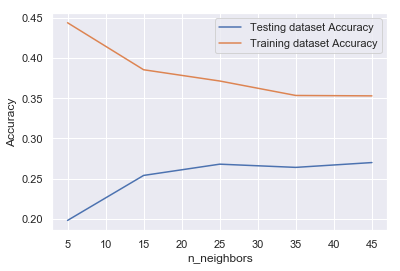

In [106]:
neighbors = np.arange(5, 50, 10) 
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
  
# Loop over K values 
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(train_x, train_y) 
      
    # Compute traning and test data accuracy 
    train_accuracy[i] = knn.score(train_x, train_y) 
    test_accuracy[i] = knn.score(test_x, test_y) 
  
# Generate plot 
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 

In [111]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(train_x, train_y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=2,
           weights='uniform')

In [112]:
print("Training dataset Accuracy")
train_accuracy = knn.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = knn.score(test_x, test_y) 
print(test_accuracy)

Training dataset Accuracy
0.3715
Testing dataset Accuracy
0.268


In [154]:
pca = PCA(n_components=48).fit(train_x)
train_x_reduce = pca.transform(train_x)

In [155]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(train_x_reduce, train_y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=2,
           weights='uniform')

In [156]:
print("Training dataset Accuracy")
train_accuracy = knn.score(train_x_reduce, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = knn.score(pca.transform(test_x), test_y) 
print(test_accuracy)

Training dataset Accuracy
0.368
Testing dataset Accuracy
0.28
